# 1. Setup and Get Data

In [ ]:
%pip install labelme tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib albumentations

### 1.1 Import Dependencies

In [1]:
import os
import time
import uuid
import cv2

### 1.2 Collect Images Using OpenCV

In [2]:
IMAGE_PATH = os.path.join('data', 'images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
  print("Collecting images {} ".format(imgnum))
  ret, frame = cap.read()

  imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('Frame', frame)
  time.sleep(0.5)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with Labels

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

In [3]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Avoid OOM errors by settings GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


### 2.3 Load Image into TF Data Pipeline

In [19]:
os.path.join(IMAGE_PATH ,'*.jpg')

'data\\images\\*.jpg'

In [ ]:
images = tf.data.Dataset.list_files(os.path.join(IMAGE_PATH ,'*.jpg'), shuffle=False)

In [9]:
images.as_numpy_iterator().next()

b'data\\images\\20ac5024-71a7-11ed-a9e4-b07b25a8233d.jpg'

In [6]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [11]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

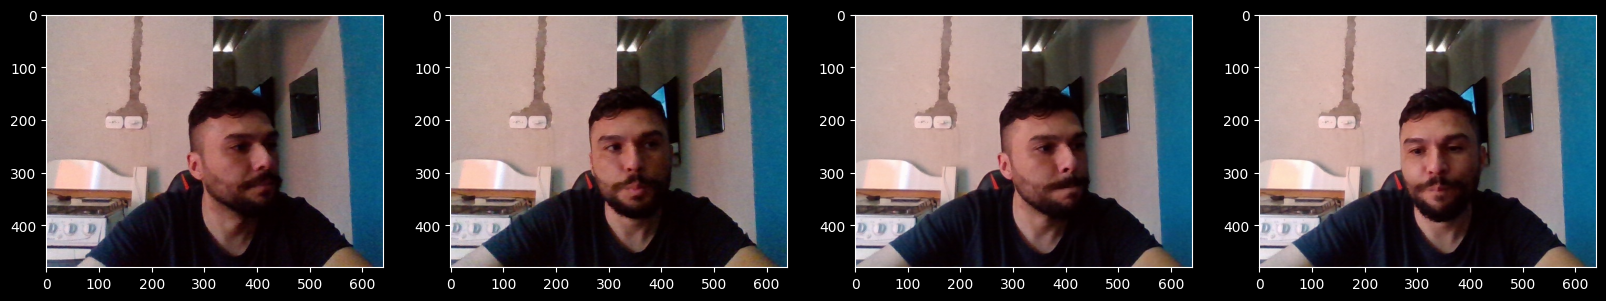

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

In [21]:
40 * .7 # 63 train

28.0

In [22]:
40 * .15 # 14 and 13 to test and val

6.0

## 3.1 Manually Split Data into Train Test and Val

### 3.2 Move the Matching Labels

In [24]:
for folder in ['train', 'test', 'val']:
  for file in os.listdir(os.path.join('data', folder, 'images')):
    file_name = file.split('.')[0] + '.json'
    existing_file_path = os.path.join('data', 'labels', file_name)
    
    if os.path.exists(existing_file_path):
      new_file_path = os.path.join('data', folder, 'labels', file_name)
      os.replace(existing_file_path, new_file_path)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumenatation Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose(
    [
        alb.RandomCrop(width=450, height=450),
        alb.HorizontalFlip(p=0.5),
        alb.RandomBrightnessContrast(p=0.2),
        alb.RandomGamma(p=0.2),
        alb.RGBShift(p=0.2),
        alb.VerticalFlip(p=0.5),
    ],
    bbox_params=alb.BboxParams(format="albumentations", label_fields=["class_labels"]),
)


### 4.2 Load a Test Image and Annotation with OpenCv and JSON

In [22]:
img = cv2.imread(
    os.path.join("data", "train", "images", "3b03f56e-71a7-11ed-868a-b07b25a8233d.jpg")
)


In [23]:
with open(
    os.path.join(
        "data", "train", "labels", "3b03f56e-71a7-11ed-868a-b07b25a8233d.json"
    ),
    "r",
) as f:
    label = json.load(f)


In [24]:
type(label)

dict

In [ ]:
label['shapes']

In [ ]:
label['shapes'][0]

In [ ]:
label['shapes'][0]['points']

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [25]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[256.88118811881185, 132.0792079207921, 422.2277227722772, 382.5742574257426]

In [27]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.4013768564356435,
 0.2751650165016502,
 0.6597308168316831,
 0.7970297029702971]

### 4.4 Apply Augmentation and View Results

In [28]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[172, 173, 182],
         [170, 172, 181],
         [170, 173, 180],
         ...,
         [138, 131, 115],
         [137, 133, 116],
         [139, 135, 118]],
 
        [[173, 172, 181],
         [170, 171, 180],
         [171, 172, 181],
         ...,
         [138, 131, 117],
         [141, 134, 120],
         [142, 138, 121]],
 
        [[174, 170, 180],
         [172, 170, 181],
         [176, 175, 184],
         ...,
         [137, 130, 117],
         [140, 132, 120],
         [142, 135, 121]],
 
        ...,
 
        [[178, 146,  55],
         [177, 147,  56],
         [176, 145,  54],
         ...,
         [218, 222, 247],
         [217, 221, 246],
         [215, 221, 243]],
 
        [[177, 144,  56],
         [176, 146,  55],
         [175, 144,  53],
         ...,
         [217, 221, 248],
         [216, 220, 247],
         [215, 220, 244]],
 
        [[175, 141,  53],
         [174, 143,  52],
         [173, 142,  51],
         ...,
         [215, 219,

In [29]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [30]:
augmented['bboxes']

[(0.352827282728273,
  0.1765016501650165,
  0.7202640264026403,
  0.7331573157315732)]

### 4.5 Draw Rectangle Image

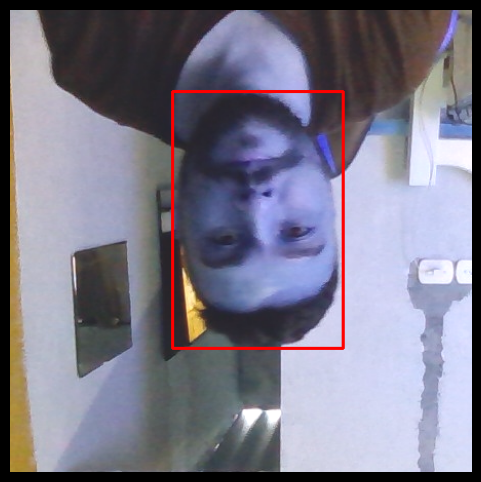

In [31]:
cv2.rectangle(
    augmented["image"],
    tuple(np.multiply(augmented["bboxes"][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(augmented["bboxes"][0][2:], [450, 450]).astype(int)),
    (255, 0, 0),
    2,
)
plt.figure(figsize=(24,6))
plt.axis('off')
plt.imshow(augmented['image'])

# 5 Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [22]:
for partition in ["train", "test", "val"]:
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join("data", partition, "labels",
                                  f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)

            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img,
                                      bboxes=[coords],
                                      class_labels=["face"])
                cv2.imwrite(
                    os.path.join('aug_data', partition, 'images',
                                 f'{image.split(".")[0]}.{x}.jpg'),
                    augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(
                        os.path.join('aug_data', partition, 'labels',
                                     f'{image.split(".")[0]}.{x}.json'),
                        'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


### 5.2 Load Augmented Images to Tensorflow Dataset

In [14]:
train_images_path = os.path.join('aug_data', 'train', 'images', '*.jpg')
train_images = tf.data.Dataset.list_files(train_images_path, shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)


In [15]:
test_images_path = os.path.join('aug_data', 'test', 'images', '*.jpg')
test_images = tf.data.Dataset.list_files(test_images_path, shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

In [ ]:
# val_images_path = os.path.join('aug_data', 'val', 'images', '*.jpg')
# val_images = tf.data.Dataset.list_files(val_images_path, shuffle=False)
# val_images = val_images.map(load_image)
# val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
# val_images = val_images.map(lambda x: x / 255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.5344363 , 0.4922794 , 0.5329044 ],
        [0.6855392 , 0.61219364, 0.6136642 ],
        [0.69099265, 0.6112132 , 0.5932598 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.35171568, 0.30759802, 0.35661766],
        [0.5382353 , 0.47297794, 0.49473038],
        [0.61403185, 0.55177695, 0.56550246],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.69626224, 0.64528185, 0.64295346],
        [0.37107843, 0.3666054 , 0.39889705],
        [0.15061274, 0.17285539, 0.24491422],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.66954654, 0.58327204, 0.5401348 ],
        [0.6657475 , 0.579473  , 0.53633577],
        [0.6789216 , 0

# 6. Prepare Labels

### 6.1 Build Labels Loading Function

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)

    return [label['class']], label['bbox']


### 6.2 Load Labels and Images Samples

In [10]:
train_labels_path = os.path.join('aug_data', 'train', 'labels', '*.json')
train_labels = tf.data.Dataset.list_files(train_labels_path, shuffle=False)
train_labels = train_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [11]:
test_labels_path = os.path.join('aug_data', 'test', 'labels', '*.json')
test_labels = tf.data.Dataset.list_files(test_labels_path, shuffle=False)
test_labels = test_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.432 , 0.1722, 0.8564, 0.7397], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Length

In [16]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(2040, 2040, 360, 360)

### 7.2 Create Final Datasets (image/label)

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [19]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### 7.3 View Image and Annotation

In [22]:
data_samples = train.as_numpy_iterator()

In [23]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


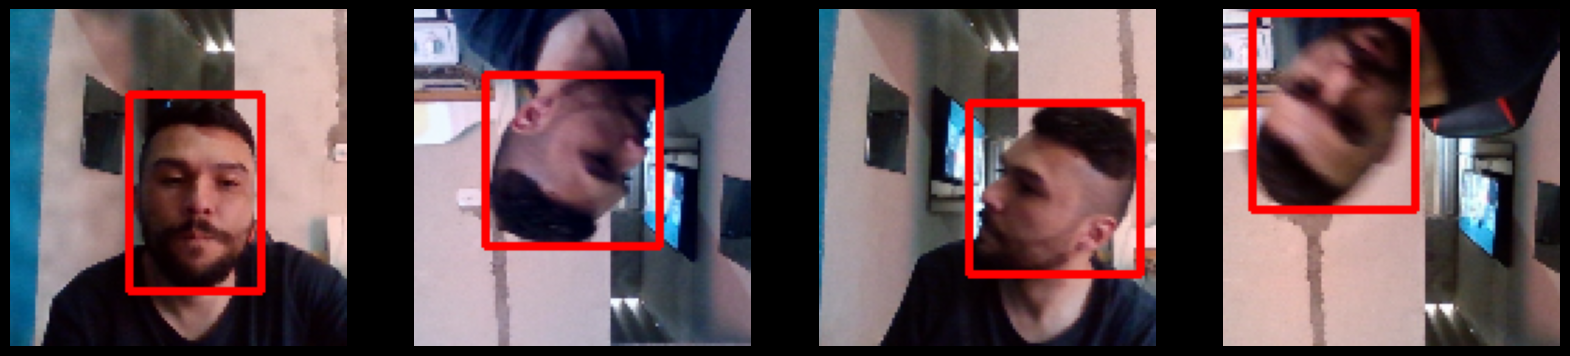

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(
        sample_image,
        tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
        (255, 0, 0), 2)

    ax[idx].axis('off')
    ax[idx].imshow(sample_image)


# 8. Build Deep Learning using Functional API

### 8.1 Import Layers and Base Network

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [26]:
vgg = VGG16(include_top=False)

In [27]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [28]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box Model
    # f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f1)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


### 8.4 Test out Neural Network

In [29]:
facetracker = build_model()

In [30]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [31]:
x, y = train.as_numpy_iterator().next()

In [32]:
x.shape

(8, 120, 120, 3)

In [33]:
classes, coords = facetracker.predict(x)

1/1 [==============================] - 24s 24s/step


In [34]:
classes, coords

(array([[0.40576956],
        [0.44672522],
        [0.52472025],
        [0.5253169 ],
        [0.50354373],
        [0.48287985],
        [0.47309595],
        [0.50454396]], dtype=float32),
 array([[0.35899362, 0.6265931 , 0.59681016, 0.41607675],
        [0.4375629 , 0.607352  , 0.65677625, 0.3539065 ],
        [0.43625394, 0.65671015, 0.5844355 , 0.411811  ],
        [0.3929779 , 0.54225874, 0.5513618 , 0.4594418 ],
        [0.4655275 , 0.63223654, 0.56702816, 0.3787601 ],
        [0.44355637, 0.6176038 , 0.59278095, 0.36108118],
        [0.2945363 , 0.62318206, 0.54291844, 0.37336493],
        [0.43258783, 0.6182393 , 0.52818847, 0.48865196]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [38]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1) / batches_per_epoch
lr_decay

0.0013071895424836598

In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)
opt

### 9.2 Create Localization Loss and Classificatin Loss

In [43]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(
        tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size


In [52]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [46]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.4799557>

In [47]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7326536>

In [53]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.4799557>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [49]:
class FaceTracker(Model):

    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        x, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(x, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_regressloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {
            'total_loss': total_loss,
            'class_loss': batch_classloss,
            'regress_loss': batch_regressloss
        }

    def test_step(self, batch, **kwargs):
        x, y = batch

        classes, coords = self.model(x, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_regressloss + 0.5 * batch_classloss

        return {
            'total_loss': total_loss,
            'class_loss': batch_classloss,
            'regress_loss': batch_regressloss
        }

    def call(self, x, **kwargs):
        return self.model(x, **kwargs)


In [50]:
model = FaceTracker(facetracker)

In [54]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [56]:
logdir = os.path.join('logs')

In [57]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [58]:
hist = model.fit(train, epochs=40, validation_data=test, callbacks=[tensorflow_callback])

Epoch 1/40
255/255 [==============================] - 136s 154ms/step - total_loss: 0.4214 - class_loss: 0.1005 - regress_loss: 0.3712 - val_total_loss: 1.0202 - val_class_loss: 0.1277 - val_regress_loss: 0.9563
Epoch 2/40
255/255 [==============================] - 30s 102ms/step - total_loss: 0.1184 - class_loss: 0.0230 - regress_loss: 0.1069 - val_total_loss: 0.2969 - val_class_loss: 0.0871 - val_regress_loss: 0.2534
Epoch 3/40
255/255 [==============================] - 30s 102ms/step - total_loss: 0.0539 - class_loss: 0.0104 - regress_loss: 0.0486 - val_total_loss: 0.2007 - val_class_loss: 0.0482 - val_regress_loss: 0.1766
Epoch 4/40
255/255 [==============================] - 31s 107ms/step - total_loss: 0.0409 - class_loss: 0.0081 - regress_loss: 0.0369 - val_total_loss: 0.0523 - val_class_loss: 7.5164e-05 - val_regress_loss: 0.0523
Epoch 5/40
255/255 [==============================] - 33s 112ms/step - total_loss: 0.0316 - class_loss: 0.0056 - regress_loss: 0.0288 - val_total_loss:

### 10.3 Plot Performance

In [59]:
hist.history

{'total_loss': [0.0819462388753891,
  0.03699500113725662,
  0.028871577233076096,
  0.009364412166178226,
  0.007017931900918484,
  0.03678404539823532,
  0.004687368869781494,
  0.006050321739166975,
  0.0020391508005559444,
  0.004219090100377798,
  0.001232360489666462,
  0.0022893152199685574,
  0.0025790489744395018,
  0.0008324605878442526,
  0.002472023479640484,
  0.0016484834486618638,
  0.0014646303607150912,
  0.0018930495716631413,
  0.002171061933040619,
  0.0018657150212675333,
  0.0007906918763183057,
  0.001050149672664702,
  0.000833821133710444,
  0.0013433020794764161,
  0.0011651302920654416,
  0.0016514301532879472,
  0.0006522767362184823,
  0.0038181710988283157,
  0.0018692591693252325,
  0.0005577434203587472,
  0.0016094400780275464,
  0.0004726569168269634,
  0.0008286331431008875,
  0.0004900018684566021,
  0.00059966353001073,
  0.0005102030117996037,
  0.0011803086381405592,
  0.0015539773739874363,
  0.00035939167719334364,
  0.0007307857158593833],
 'cl

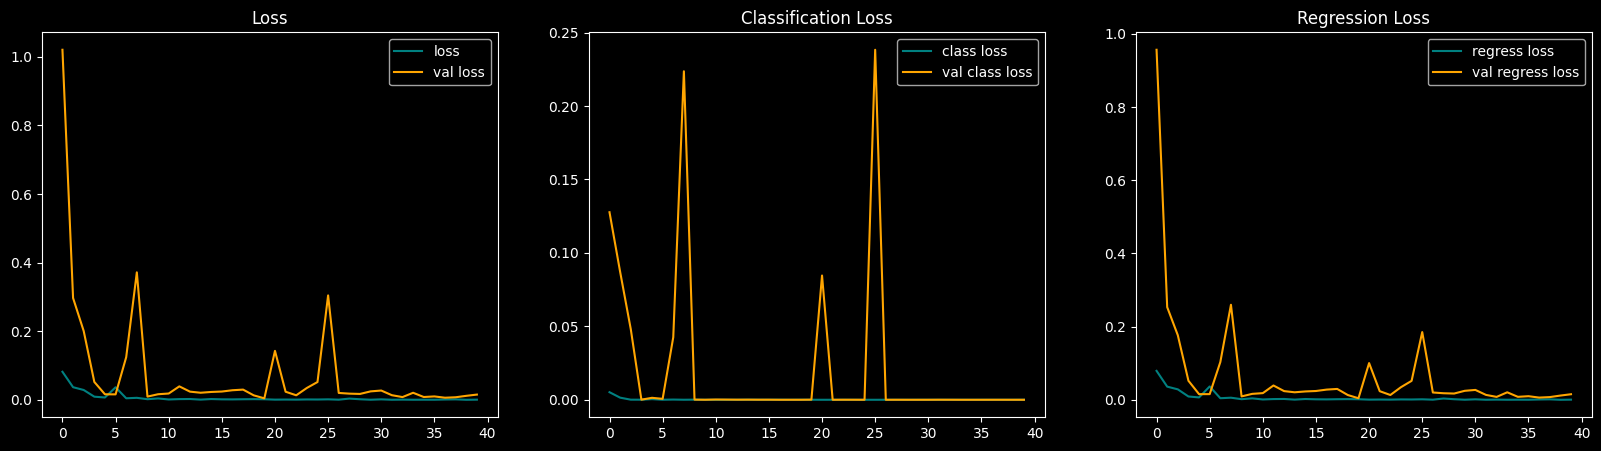

In [62]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label="loss")
ax[0].plot(hist.history['val_total_loss'], color='orange', label="val loss")
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label="class loss")
ax[1].plot(hist.history['val_class_loss'], color='orange', label="val class loss")
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label="regress loss")
ax[2].plot(hist.history['val_regress_loss'], color='orange', label="val regress loss")
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make predictions

###  11.1 Make Predictions on Test Set

In [63]:
test_data = test.as_numpy_iterator()

In [89]:
test_sample = test_data.next()

In [90]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


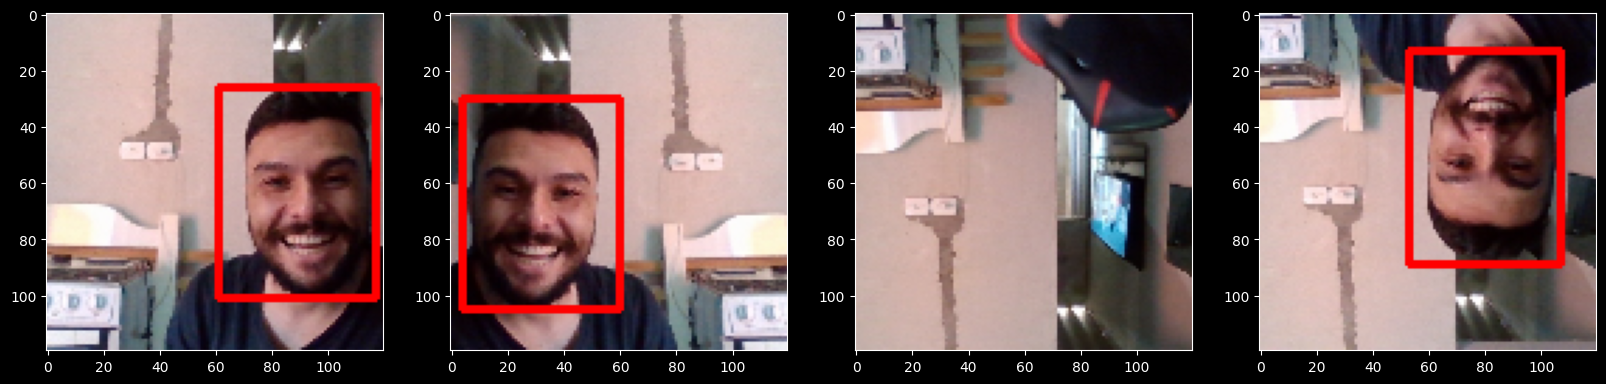

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [92]:
from tensorflow.keras.models import load_model

In [93]:
facetracker.save('facetracker.h5')

In [94]:
del facetracker

In [95]:
facetracker = load_model('facetracker.h5')
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

### 11.3 Real Time Detection

In [102]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.9:
        # control the main rectangle
        cv2.rectangle(
            frame,
            tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
            tuple(np.multiply(sample_coords[2:],
                              [450, 450]).astype(int)), (255, 0, 0), 2)

        # control the label rectangle
        cv2.rectangle(
            frame,
            tuple(
                np.add(
                    np.multiply(sample_coords[:2], [450, 450]).astype(int),
                    [0, -30])),
            tuple(
                np.add(
                    np.multiply(sample_coords[:2], [450, 450]).astype(int),
                    [80, 0])), (255, 0, 0), -1)

        # controls the text rendered
        cv2.putText(
            frame, 'face',
            tuple(
                np.add(
                    np.multiply(sample_coords[:2], [450, 450]).astype(int),
                    [0, -5])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
            cv2.LINE_AA)

    cv2.imshow('EyeTack', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step


In [97]:
cap.release()
cv2.destroyAllWindows()